In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
version = input()

In [3]:
dti_folder = f"/biodata/nyanovsky/datasets/dti/processed/{version}/"

In [4]:
import pickle
G = pickle.load(open(dti_folder+"dti_graph.pickle",'rb'))

In [5]:
def get_rel_subgraph(G: nx.Graph, rel: str) -> nx.Graph:
    rel_edges = [(u,v) for (u,v,r_dict) in G.edges.data() if r_dict["edge_type"]==rel]
    rel_subgraph = G.edge_subgraph(rel_edges).copy()
    return rel_subgraph

In [6]:
ChG_subgraph = get_rel_subgraph(G, "chg")
ChCh_subgraph = get_rel_subgraph(G, "chch")
GG_subgraph = get_rel_subgraph(G, "gg")

In [13]:
def sample_avg_shortest_path_length(G,n):
    nodes = G.nodes()
    lengths = []
    for _ in range(n):
        u,v = np.random.choice(nodes, 2)
        d = nx.shortest_path_length(G, u, v)
        lengths.append(d)
    return np.mean(lengths)


In [17]:
stats_df = pd.DataFrame(columns=["num nodes", "num edges", "% GC", "distancia media aproximada", "diam aproximado"], index=["full network", "Chemical-Chemical", "Chemical-Gene", "Gene-Gene"])

def get_stats(graph: nx.Graph):
    num_nodes, num_edges = graph.number_of_nodes(), graph.number_of_edges()

    gc = nx.subgraph(graph,max(nx.connected_components(graph), key=len))

    frac_gc = round(gc.number_of_nodes()/num_nodes,3) 

    avg_d = sample_avg_shortest_path_length(gc, 5000)
    approx_diam = nx.approximation.diameter(gc)
    return [num_nodes, num_edges, frac_gc, avg_d, approx_diam]

In [18]:
for i, g in enumerate([G, ChCh_subgraph, ChG_subgraph, GG_subgraph]):
    stats_df.iloc[i,:] = get_stats(g)

In [21]:
stats_df

,num nodes,num edges,% GC,distancia media aprox,diametro aprox
full network,11659,80221,0.999,3.8994,10
Chemical-Chemical,4469,20000,0.597,8.4232,29
Chemical-Gene,11659,38391,0.983,4.4058,13
Gene-Gene,3569,21830,0.395,6.1176,15


In [13]:
from collections import Counter
plt.style.use("ggplot")

In [7]:
import seaborn as sns

In [9]:
def dists_to_subgraph(sources, targets):
    dists_to_trgt= [] # (avg, min, max)
    for node in sources:
        dists = nx.single_source_shortest_path_length(G, source=node)
        to_subgraph = []
        for target in targets:
            try:
                to_subgraph.append(dists[target])
            except:
                continue
        if len(to_subgraph) > 0:
            avg, min_d, max_d = np.mean(to_subgraph), min(to_subgraph), max(to_subgraph)
            dists_to_trgt.append((avg, min_d, max_d))
        else:
            dists_to_trgt.append("not_reachable")
            
    reachables = [x for x in dists_to_trgt if x != "not_reachable"]
            
    print(f"not reachable: {len(sources)-len(reachables)}")        
    return reachables

In [8]:
genes = [node for node in G.nodes() if node.startswith("G")]
drugs = [node for node in G.nodes() if node.startswith("C")]

not_connected_genes = [gene for gene in genes if gene not in GG_subgraph.nodes()]
not_connected_drugs = [drug for drug in drugs if drug not in ChCh_subgraph.nodes()]

gc_nodes = list(max(nx.connected_components(G), key=len))

In [16]:
ds_nc_genes_to_gc = dists_to_subgraph(not_connected_genes, gc_nodes)
ds_nc_drugs_to_gc = dists_to_subgraph(not_connected_drugs, gc_nodes)

not reachable: 6
not reachable: 7


In [9]:
plt.style.use("bmh")

Text(0, 0.5, 'proporcion')

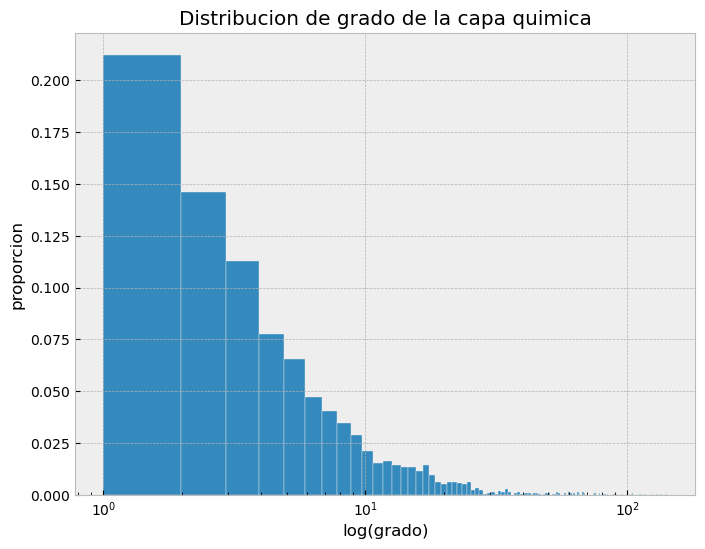

In [10]:
plt.figure(figsize=(8,6))
ChCh_degs = [deg for node, deg in ChCh_subgraph.degree()] #type: ignore
sns.histplot(ChCh_degs, bins=145, alpha=1, stat="proportion")
plt.xscale("log")
plt.title("Distribucion de grado de la capa quimica")
plt.xlabel("log(grado)")
plt.ylabel("proporcion")

Text(0, 0.5, 'proporcion')

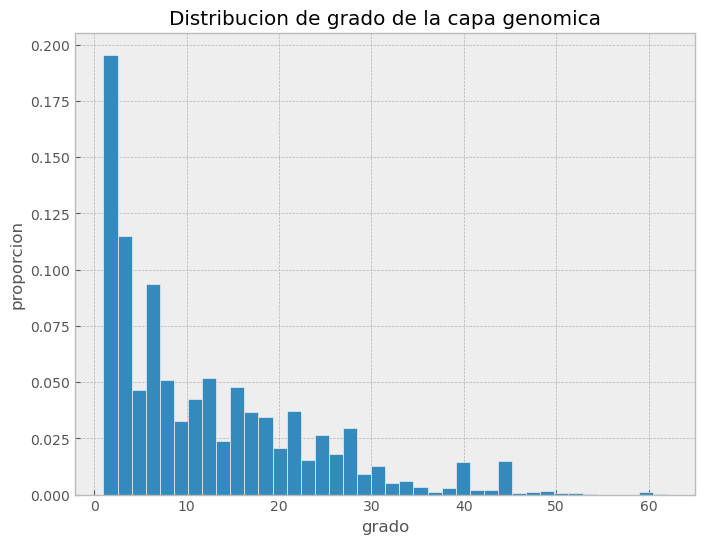

In [16]:
plt.figure(figsize=(8,6))
GG_degs = [deg for node, deg in GG_subgraph.degree()] #type: ignore
sns.histplot(GG_degs, bins=40, alpha=1, stat="proportion")
plt.title("Distribucion de grado de la capa genomica")
plt.xlabel("grado")
plt.ylabel("proporcion")

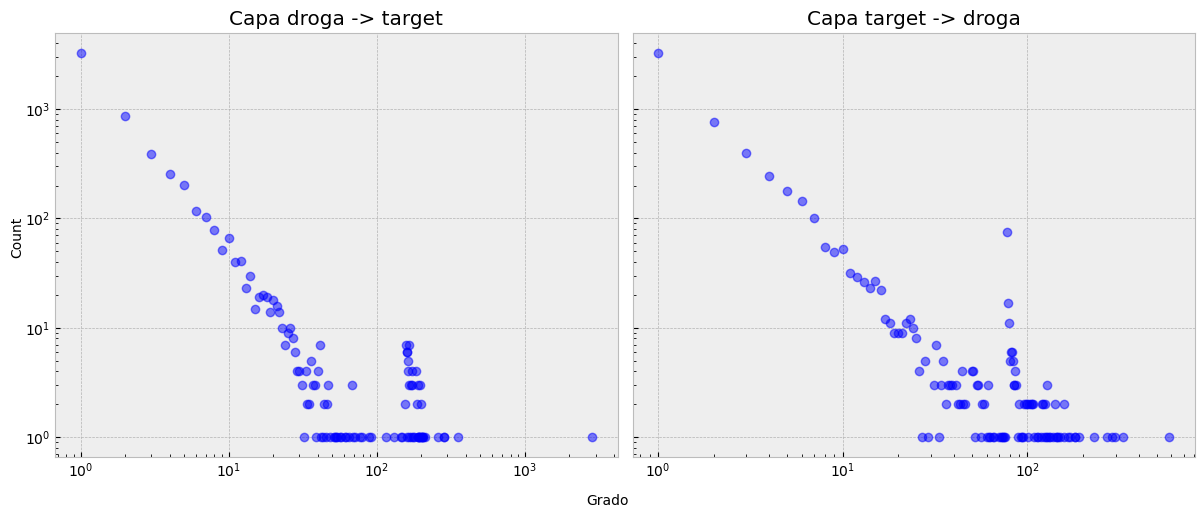

In [16]:
fig,axes = plt.subplots(1,2,figsize=(12,5), sharey=True)

ChG_degs = [deg for node, deg in ChG_subgraph.degree() if node in drugs] #type: ignore
GCh_degs = [deg for node, deg in ChG_subgraph.degree() if node in genes] #type: ignore

deg1, counts1 = zip(*Counter(ChG_degs).items())
deg2, counts2 = zip(*Counter(GCh_degs).items())

axes[0].loglog(deg1, counts1, "bo", alpha=0.5)
axes[0].set_title("Capa droga -> target")
axes[1].loglog(deg2, counts2, "bo", alpha=0.5)
axes[1].set_title("Capa target -> droga")

fig.text(x=0.48,y=-0.02,s="Grado")
fig.text(x=0,y=0.48,s="Count", rotation="vertical")

plt.tight_layout()
plt.show()

In [111]:
ChG_degs = [deg for node, deg in ChG_subgraph.degree()] #type: ignore
deg, counts = zip(*Counter(ChG_degs).items())

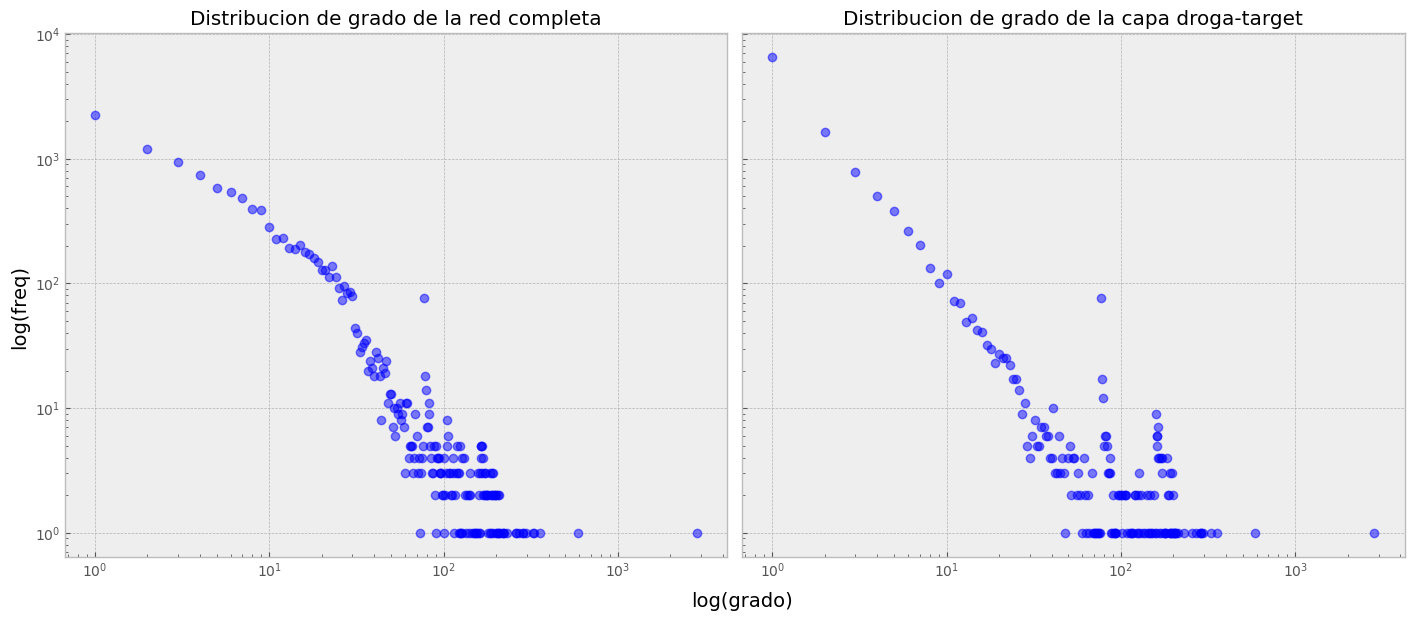

In [140]:
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)

axes[0].loglog(v, c, "bo", alpha=0.5)
axes[1].loglog(deg, counts, "bo", alpha=0.5)

axes[0].set_title("Distribucion de grado de la red completa")
axes[1].set_title("Distribucion de grado de la capa droga-target")

fig.text(0.48, -0.02, "log(grado)", fontsize=14)
fig.text(0, 0.48, "log(freq)", ha="center",va="center", rotation="vertical", fontsize=14)

plt.tight_layout()
plt.show()

Veamos transitividad en la red, i.e cuantos triangulos se cierran de la forma Ch-Ch-G o G-G-Ch (Quiero ver si compuestos similares se pegan a las mismas proteinas, o si proteinas similares son targeteadas por el mismo compuesto)

In [15]:
def ChG_triangles(ChG_net):
    ChG_triangles = 0
    for u,v in ChG_net.edges():
        if u.startswith("C") and v.startswith("G"):
            chem, gene = u,v 
        else:
            chem, gene = v,u
        if chem in ChCh_subgraph.nodes():
            chem_neighs = ChCh_subgraph.neighbors(chem)
            for neigh in chem_neighs:
                if (neigh, gene) in ChG_net.edges() or (gene, neigh) in ChG_net.edges():
                    ChG_triangles += 1
        if gene in GG_subgraph.nodes():
            gene_neighs = GG_subgraph.neighbors(gene)
            for neigh in gene_neighs:
                if (neigh, chem) in ChG_net.edges() or (chem, neigh) in ChG_net.edges():
                    ChG_triangles += 1
    return ChG_triangles

In [16]:
ChG_connected_triplets = 0
for node in ChG_subgraph.nodes():
    if node in ChCh_subgraph.nodes() or node in GG_subgraph.nodes(): 
        # hay nodos de altisimo grado (como el Ca2+, o los citocromos) que no tienen conexiones con otras drogas/proteinas, 
        # no le veo sentido contar los posibles tripletes que puedan formar. 
        ChG_connected_triplets += len(set(ChG_subgraph.neighbors(node))) * (len(set(ChG_subgraph.neighbors(node)))-1)/2

        # esto funciona porque el subgrafo es bipartito, nunca se cuentan tripletes dos veces

In [17]:
valor_real = ChG_triangles(ChG_subgraph)/ChG_connected_triplets

In [18]:
ChG_subgraph.number_of_edges()

38391

In [13]:
import concurrent.futures

In [20]:
ChG_net = ChG_subgraph.copy()
def calc_triangle_coef(ChG_net):
    net = ChG_net.copy()
    nx.double_edge_swap(net,38000, 100000)
    return ChG_triangles(net)/ChG_connected_triplets

In [22]:
num_cores = 16
reps = 1000
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(calc_triangle_coef, [ChG_net] * reps))

frac_triangulos = results

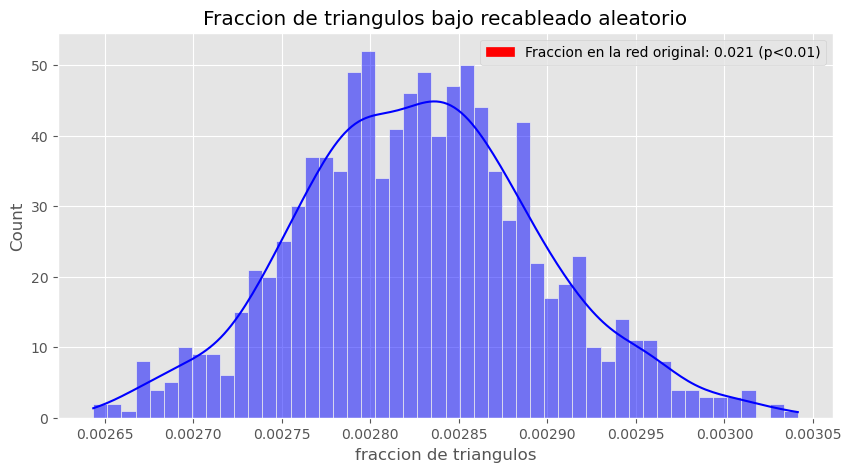

In [23]:
import seaborn as sns
from matplotlib.patches import Patch
custom_legend = [Patch(color='red', label=f'Fraccion en la red original: {valor_real:.3f} (p<0.01)')]

plt.figure(figsize=(10,5))
sns.histplot(frac_triangulos, bins=50, kde=True, color="blue",alpha=0.5)
plt.title("Fraccion de triangulos bajo recableado aleatorio")
plt.xlabel("fraccion de triangulos")
plt.legend(handles=custom_legend, loc="upper right")

### Analisis de comunidades

In [19]:
import community as community_louvain

In [20]:
comunidades_chch = community_louvain.best_partition(ChCh_subgraph, random_state=42)
comunidades_gg = community_louvain.best_partition(GG_subgraph, random_state=42)

In [30]:
len([node for node in G.nodes() if node.startswith("G")])

5805

In [120]:
node_df = pd.read_csv(dti_folder+"node_df.csv")

In [124]:
def get_com(node_id):
    if node_id.startswith("C"):
        try:
            return comunidades_chch[node_id]
        except:
            return "not connected"
    elif node_id.startswith("G"):
        try:
            return comunidades_gg[node_id]
        except:
            return "not connected"

In [128]:
node_df["louvain community (nodetype subgraph)"] = node_df["node_id"].apply(get_com)

In [130]:
node_df.to_csv(dti_folder+"node_df.csv", index=False) # quizas agregar a tensor df

In [34]:
ids = []
with open(dti_folder+"prot_features_ids.txt", "r") as file:
    for line in file:
        ids.append("G"+line.strip())

In [36]:
len([x for x in GG_subgraph.nodes() if x in ids])/len(GG_subgraph)

0.6281871672737461

In [37]:
genes = [x for x in G.nodes() if x.startswith("G")]
len([x for x in genes if x in ids])/len(genes)


0.5669250645994832

In [39]:
len(GG_subgraph)*0.6281871672737461

2242.0

In [45]:
len(genes)*0.5669250645994832-2242

1049.0

In [46]:
len(genes)-len(GG_subgraph)

2236

In [47]:
not_connected_genes = [node for node in genes if node not in GG_subgraph.nodes()]

In [103]:
def dists_to_subgraph(sources, targets):
    dists_to_trgt= [] # (avg, min, max)
    for node in sources:
        dists = nx.single_source_shortest_path_length(G, source=node)
        to_subgraph = []
        for target in targets:
            try:
                to_subgraph.append(dists[target])
            except:
                continue
        if len(to_subgraph) > 0:
            avg, min_d, max_d = np.mean(to_subgraph), min(to_subgraph), max(to_subgraph)
            dists_to_trgt.append((avg, min_d, max_d))
        else:
            dists_to_trgt.append("not_reachable")
            
    reachables = [x for x in dists_to_trgt if x != "not_reachable"]
            
    print(f"not reachable: {len(sources)-len(reachables)}")        
    return reachables

In [104]:
reachables_gg_sub = dists_to_subgraph(not_connected_genes, GG_subgraph.nodes())

not reachable: 6


<Axes: ylabel='Count'>

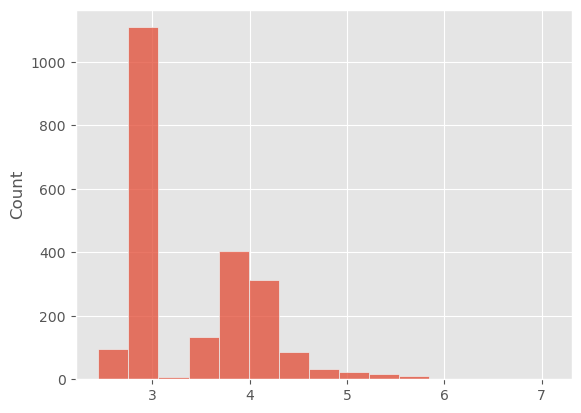

In [105]:
sns.histplot([x[0] for x in reachables_gg_sub], bins=15)

In [106]:
min_d, min_counts =  zip(*Counter([x[1] for x in reachables_gg_sub]).items())
max_d, max_counts =  zip(*Counter([x[2] for x in reachables_gg_sub]).items())

Text(0.5, 1.0, 'max distances from not connected genes to connected')

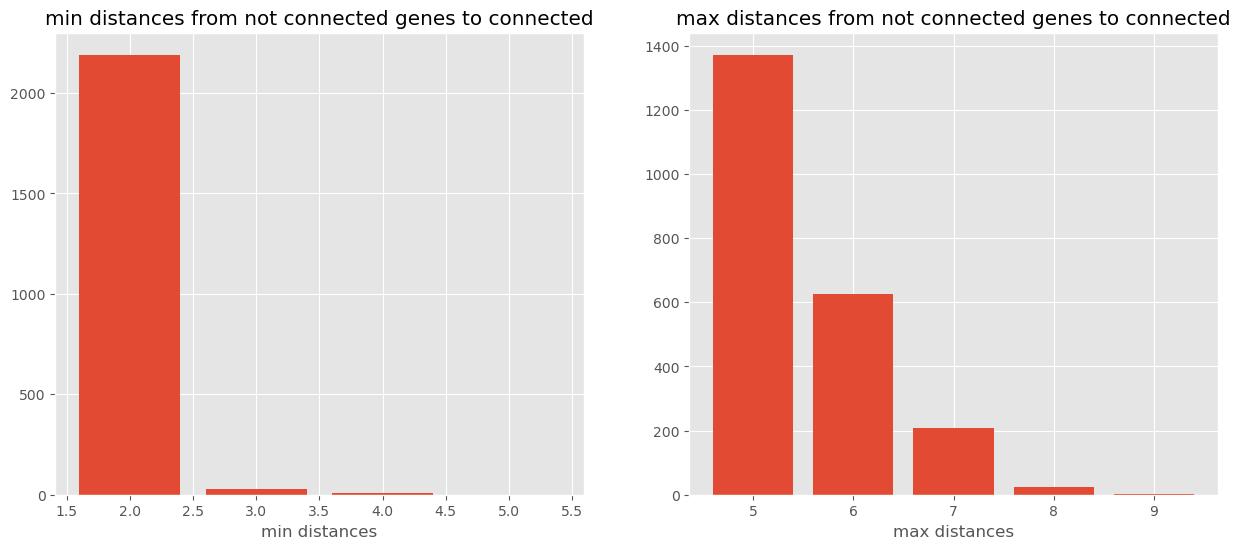

In [107]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].bar(min_d, min_counts)
axes[0].set_xlabel("min distances")
axes[0].set_title("min distances from not connected genes to connected")

axes[1].bar(max_d, max_counts)
axes[1].set_xlabel("max distances")
axes[1].set_title("max distances from not connected genes to connected")



#### Vemos lo mismo pero para los que tienen features

In [151]:
ids = []
with open("/biodata/nyanovsky/datasets/dti/processed/v2/prot_features_ids.txt",'r') as file:
    for line in file:
        ids.append("G"+line.strip())

In [153]:
genes_with_features = [x for x in genes if x in ids]
genes_with_no_features = [x for x in genes if x not in ids]

In [156]:
len(genes_with_features) 

3291

In [157]:
dists_to_features = dists_to_subgraph(genes_with_no_features, genes_with_features)

not reachable: 0


In [158]:
avg_to_feats, min_to_feats, max_to_feats = np.array(dists_to_features).T

<Axes: ylabel='Count'>

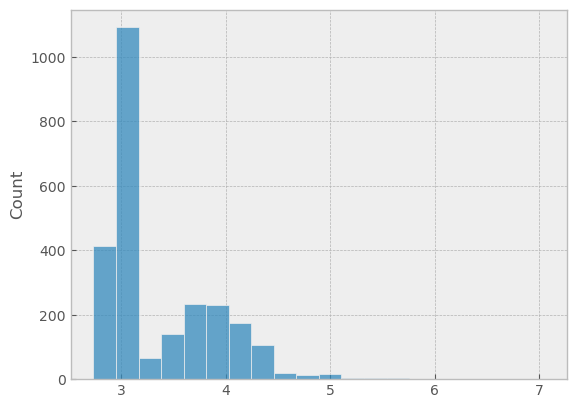

In [159]:
sns.histplot(avg_to_feats, bins=20)

In [160]:
min_d_to_feats, min_counts_to_feats =  zip(*Counter(min_to_feats).items())
max_d_to_feats, max_counts_to_feats =  zip(*Counter(max_to_feats).items())

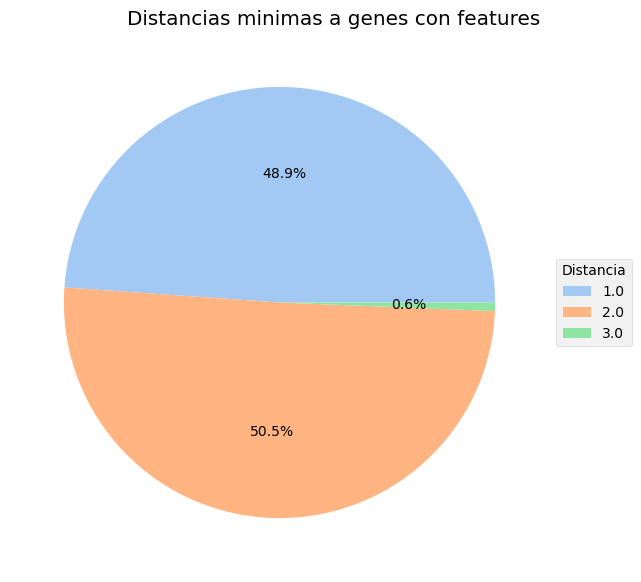

In [181]:
plt.figure(figsize=(7, 7))  # Set figure size
wedges, _, _= plt.pie(min_counts_to_feats, autopct='%1.1f%%', colors=sns.color_palette("pastel"))

# Add a legend to display values
plt.legend(wedges, min_d_to_feats, title="Distancia", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Display the pie chart
plt.title('Distancias minimas a genes con features',x=0.6)
plt.show()